**Author**: Yap Jheng Khin

**FYP II Title**: Used car dealership web application

**Purpose**:
- This notebook highlights the transfer learning process from traditional random forest classifier (Scikit-learn API) to adaptive random forest classifier (River API).
- Ouput
    - Experiment data for reproducibility.
    - Data preprocessor for reproducibility. 
    - Trained TRF for reproducibility. 
    - ARF classifier with the transfered weight. 
    - Diagram of the first decision tree and Hoeffding tree for comparison.
    - Log files that prove the correctness of the transfer learning algorithm.

**Technical jargon**
1. ARF - Adaptive random forest
2. TRF - Traditional random forest

**Execution time**: At most 20 minutes in Jupyter Notebook with 8 processor cores.

# Setup

Ensure that the current Python interpreter path is correct. For example, if the **River conda environment** is named as **arf_conda_env**, the expected `sys.executable` should be C:\Users\User\miniconda3\envs\\**arf_conda_env**\\python.exe.

In [ ]:
import sys
print(sys.executable)

## Import

Import libraries.

In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import pickle

# scikit-learn model
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree as sklearn_tree

# River model and its components
from river.ensemble import AdaptiveRandomForestClassifier
from river.drift import ADWIN

# Data Generator
from skmultiflow.data import AGRAWALGenerator, ConceptDriftStream
from sklearn.model_selection import train_test_split

# User libraries
from data_preprocessing import DataPreprocessor
from arf_cf_transfer_learning import transfer_learning, transfer_tree_weights_test, dt_fetch_data
from arf_training import train_arf_cf

Initialise seed for reproducibility.

In [2]:
#Intialise a random number generator
# Source: https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
RANDOM_SEED = 2022
RANDOM_NUMBER_GENERATOR = np.random.default_rng(RANDOM_SEED)

OUT_PARENT_DIR = 'outputs'
OUT_CHILD_DIR = 'cf_transfer_learning'
OUT_FOLDER_PATH = os.path.join(OUT_PARENT_DIR, OUT_CHILD_DIR) 

# Create directory if not exist
os.makedirs(OUT_FOLDER_PATH, exist_ok=True)

##  Data Setup

1. To verify the ARF's performance under concept drift, it would be suitable to use a more robust concept drift generator like `ConceptDriftStream`. The documentation of concept drift generator was found at [here](https://scikit-multiflow.readthedocs.io/en/stable/api/generated/skmultiflow.data.ConceptDriftStream.html).

2. Instead of using the application data, the author used the [AGRAWAL stream generator](https://scikit-multiflow.readthedocs.io/en/stable/api/generated/skmultiflow.data.AGRAWALGenerator.html#skmultiflow.data.AGRAWALGenerator) as the experimental data since the concept drift stream generator was API-specific and don't handle general data structure like `numpy.ndarray` or `pandas.DataFrame`. In other words, `ConceptDriftStream` only supported its own data generator like `AGRAWALGenerator`.

3. To ensure the experimental data was as realistic as possible, the `perturbation` parameter was set to 0.05 to introduce some noise into the data. 

In [3]:
# Generate stream generator representing the offline data
train_data = AGRAWALGenerator(
    balance_classes=True, 
    classification_function=0, 
    perturbation=0.05,
    random_state=RANDOM_SEED)

# Generate stream generataor representing the online data
# The classification function was set to value other than 1 to generate different data distribution
drift_data = AGRAWALGenerator(
    balance_classes=True, 
    classification_function=1, 
    perturbation=0.05, 
    random_state=RANDOM_SEED)

# Generate a concept drift stream by concatenating two streams together
# The next 30000 instances would suffer concept drift after the initial 30000 instances
concept_drift_stream = ConceptDriftStream(
    stream=train_data, 
    drift_stream=drift_data, 
    position=30000, width=30000, 
    random_state=RANDOM_SEED)

`AGRAWALGenerator` generates:
- continuous features which are `salary`, `commission`, `age`, `hvalue` (house's value), `hyears` (# years of having house's ownership) and `loans` (amount of money to borrow).
- categorical features which are `elevel` (education level), `car` (owned car's brand), `zipcode` (town's zipcode).
- target variable that determines whether the loan application should be approved (`1`) or not (`0`). It's a classification task.

In [4]:
# Obtain the feature names from the stream generator
X_attrs = concept_drift_stream.feature_names
y_attr = ['target']

X_attrs

['salary',
 'commission',
 'age',
 'elevel',
 'car',
 'zipcode',
 'hvalue',
 'hyears',
 'loan']

Extract the data from the stream generator.
1. The first 30,000 samples were **offline** data initially used in training algorithms. This data was used to test models' performance without concept drift. 
2. The last 30,000 samples were **online** data that experience concept drift over time. This data was used to test models' performance under concept drift. 
3. 5,000 samples out of 30,000 samples would be used to check model's generalisation error.
4. The offline data is shuffled since the data is fully available, while online data is not shuffled since the data is only continuously arrived over time.

In [5]:
X_offline, y_offline = concept_drift_stream.next_sample(batch_size = 30000)
# Shuffle offline data since the data is fully available
X_train, X_test, y_train, y_test = train_test_split(
    X_offline, 
    y_offline, 
    test_size=5000, 
    random_state=RANDOM_SEED, 
    shuffle=True
)
# Do not shuffle online data since the data is continuously arrived over time
X_train_drifted, y_train_drifted = concept_drift_stream.next_sample(batch_size = 25000)
X_test_drifted, y_test_drifted = concept_drift_stream.next_sample(batch_size = 5000)

with open(os.path.join(OUT_FOLDER_PATH, 'exp_data_for_cf.npy'), 'wb') as f:
    np.save(f, y_train)
    np.save(f, y_test)
    np.save(f, y_train_drifted)
    np.save(f, y_test_drifted)
    np.save(f, X_train)
    np.save(f, X_test)
    np.save(f, X_train_drifted)
    np.save(f, X_test_drifted)

# Convert to dataframe
X_train = pd.DataFrame(X_train, columns = X_attrs)
X_test = pd.DataFrame(X_test, columns = X_attrs)
X_train_drifted = pd.DataFrame(X_train_drifted, columns = X_attrs)
X_test_drifted = pd.DataFrame(X_test_drifted, columns = X_attrs)

print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')
print(f'X_train_drifted shape {X_train_drifted.shape}')
print(f'y_train_drifted shape {y_train_drifted.shape}')
print(f'X_test_drifted shape {X_test_drifted.shape}')
print(f'y_test_drifted shape {y_test_drifted.shape}')

X_train shape (25000, 9)
y_train shape (25000,)
X_test shape (5000, 9)
y_test shape (5000,)
X_train_drifted shape (25000, 9)
y_train_drifted shape (25000,)
X_test_drifted shape (5000, 9)
y_test_drifted shape (5000,)


# Training

## Random Forest

### Model Setup

In [6]:
trf_cf_params = {
    # Random forest hyperparameters
    'n_estimators': 100, # Train 100 decision trees
    'criterion': 'gini', # The feature selection criterion was Gini impurity
    'max_depth': None, # No restriction on the maximum depth of trees
    'max_features': 'sqrt', # The number of features to consider when looking for the best split
    'random_state': RANDOM_SEED,
    
    # Traditional random forest algorithm-specific hyperparameters
    'bootstrap': True, # Different subset of dataset in each tree
    'max_leaf_nodes': None, # Can produce unlimited number of leaf nodes
    'min_samples_leaf': 1, # Miminum number of samples required to be at leaf node
    'min_samples_split': 50, # Minimum number of samples to split node. Must match with grace period.
    'min_weight_fraction_leaf': 0.0, # Samples have equal weight at leaf node

    # Utility parameters
    'n_jobs': -1, # Use all available processors
    'verbose': 0,
    'warm_start': False, # Fit a whole new forest
}

### Training

Initialise data preprocessor.

In [7]:
# Preprocess data
# Return training data, the feature names, and the categorical features names after data preprocessing
cat_attrs = ['car', 'zipcode']
num_attrs = ['hvalue', 'salary', 'loan', 'commission', 'elevel', 'hyears', 'age']

data_pp = DataPreprocessor(X_train, num_attrs, cat_attrs)

Perform hyperparameter tunning to optimise TRF.

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Relevant hyperparameters to reduce generalisation errors
trf_cf_param_dist = {
    'n_estimators': [5, 10, 15, 20], # The number of decision trees
    'max_depth': [5, 10, 15, 20], # The maximum depth of decision trees
}

# Training
duration = 0
start = time.time()

trf_cf_cv = RandomizedSearchCV(
    RandomForestClassifier(**trf_cf_params), trf_cf_param_dist, 
    n_iter = 10, scoring = 'roc_auc', n_jobs = -1, 
    refit=True, cv = 10, verbose = 10, 
    random_state = RANDOM_SEED, return_train_score = False)

X_train_pp = data_pp.preprocess(X_train)

trf_cf_search = trf_cf_cv.fit(X_train_pp, y_train)

end = time.time()
duration += end - start
print(f'\nTime taken for tunning TRF: {duration} seconds')

Fitting 10 folds for each of 10 candidates, totalling 100 fits

Time taken for tunning TRF: 15.594496250152588 seconds


Fit the TRF using the best hyperparameter settings.

In [9]:
# Training
duration = 0
start = time.time()

# Update the hyperparameters
for param_name, param_value in trf_cf_search.best_params_.items():
    trf_cf_params[param_name] = param_value

# Define a classifier
trf_cf = RandomForestClassifier(**trf_cf_params)

trf_cf.fit(X_train_pp, y_train)

end = time.time()
duration += end - start

print(f'\nTime taken for training TRF: {duration} seconds')


Time taken for training TRF: 0.18476390838623047 seconds


Below is the overall description of the fitted TRF classifier.

In [10]:
total_depth = 0
total_estimators = trf_cf.n_estimators
print(f'The total number of base learners is {trf_cf.n_estimators}.')

for estimator in trf_cf.estimators_:
    total_depth += estimator.get_depth()

print(f'The depth of each base learner is {math.floor(total_depth/total_estimators)} on average.')

The total number of base learners is 15.
The depth of each base learner is 20 on average.


## Hoeffding tree

### Model Setup


In [11]:
river_adwin = ADWIN(delta = 0.002)

river_arf_cf_params = {
    # Random forest hyperparameters
    'n_models': len(trf_cf.estimators_), # Number of base learners
    'max_depth': None, # No restriction on the maximum depth of trees
    'max_features': 'sqrt', # The number of features to consider when looking for the best split
    'seed': RANDOM_SEED,
    'split_criterion': 'gini', # Set criterion as Gini impurity

    # Adaptive random forest algorithm-specific hyperparamters
    'binary_split': True, # Enforce binary split and disable multi-way split
    'disable_weighted_vote': False, # Enable weighted vote prediction
    'drift_detector': river_adwin, # Drift Detection method.
    'grace_period': 50, # Number of instances a leaf should observe between split attempts
    'lambda_value': 6, # The lambda value for bagging
    'leaf_prediction': 'mc', # Perform Majority Class prediction at the leaves
    'split_confidence': 0.01, # Allowed error in split decision
    'splitter': None, # Use tree.splitter.GaussianSplitter to monitor the class statistics and perform splits
    'tie_threshold': 0.05, # Threshold below which a split will be forced to break ties. 
    'warning_detector': river_adwin, # Warning Detection method.

    # Utility hyperparameters
    'max_size': 100, # Maximum memory (MB) consumed by the tree.
    'nominal_attributes': data_pp.nominal_attrs, # List of nominal attributes.
    'merit_preprune': False # Disable merit-based tree pre-pruning.
}

### Transfer Learning

The source code for transfer learning can be found at **arf_cf_transfer_learning.py**.

*A)* Pseudocode for transfer_tree_weights is as shown below:

```
FOR each hoeffding_tree
    ENQUEUE root_node to queue
    
    WHILE queue is not empty
        DEQUEUE node from queue
        
        Retrieve left and right child indexes from the corresponding node in decision_tree
        Retrieve prediction_value from the corresponding node in decision_tree
        
        IF left child index is -1 (node is a leaf node)
            CALL learn_many to update the node's statistics and splitters
        ELSE
            Retrieve split feature and split value from the corresponding node in decision_tree
            
            IF split feature is categorical
                Update the split value to 0
            
            CREATE branch_node and two child_node
            ATTACH the two child_node to the branch_node
            REATTACH branch_node to its parent to update object reference
            
            Update the statistics at the branch_node with the prediction_value           
            
            ENQUEUE the two child_node into queue
```

The split value is overriden with value 0 whenever the split feature is categorical. It is because split conditions are different for both scikit-learn implementation of decision tree and River implementation of Hoeffding tree. For TRF, the split value is set at 0.5 and the leaf node's traversal happens when the feature value is less than 0.5. For ARF, the split value is set at a categorical value and the leaf node's traversal happens when the feature value is exactly equivalent to the split value. Thus, it is assumed all the nominal features are one-hot encoded, such that the TRF's split value is always 0.5 for easier implementation of transfer leearning.

In TRF, the prediction value is an array of two numbers. For the parent nodes, the two numbers are defined as the number of training samples that are traversed to left and right child node, respectively. For the leaf nodes, the two numbers are used to predict the class label using majority rule. For binary classification, if the left-side number is larger than right-side number, then the predicted class label is negative and vice versa. The prediction value is copied to the newly created branch node's object and leaf node's object in the ARF during transfer learning. 

Due to time constraint, the transfer learning classifier algorithm has limitations. 

1. The algorithm only supports the transfer of weights between binary classifiers, but not multiclass classifiers or multilabel classifiers. 

2. The algorithm also only supports the update of two specific splitters in Hoeffding tree. The two splitters are the <a href="https://riverml.xyz/latest/api/tree/splitter/GaussianSplitter/">GaussianSplitter</a> for the numerical splitter and <a href="https://github.com/online-ml/river/blob/c0c88d38b96c99de3e3646005c3ded1bfee47e47/river/tree/splitter/nominal_splitter_classif.py#L8">NominalSplitterClassif</a> for nominal splitter. 

3. The algorithm only supports transferring to Hoeffding trees that are configured to use **majority class** leaf prediction mechanism, but not **Naive Bayes** mechanism or **Naive Bayes Adaptive** mechanism. 

4. The pre-trained Hoeffding trees can only perform binary split, but not multi-way split. The Hoeffding tree is enforced to only perform binary split since scikit-learn decision tree only performs binary split. 

Logically speaking, the max depth allowed in Hoeffding tree must be equivalent or larger than the max depth allowed in decision tree for the transfer learning to work as expected. Note that the transfer learning algorithm is not fully tested when the merit-based tree pre-pruning is enabled.

Based on the limitation above, the hyperparameter of TRF and ARF must be set as shown below:
```python
river_arf_cf_params = {
    'n_models': len(trf_cf.estimators_), # Number of base learners must be the same with TRF
    'max_depth': None, # Should be equal or larger than max_depth in decision tree
    'binary_split': True, # Enforce binary split and disable multi-way split
    'leaf_prediction': 'mc', # Perform Majority Class prediction at the leaves
    'splitter': None, # Use tree.splitter.GaussianSplitter to monitor the class statistics and perform splits
    
    # Hyperparameter that is not fully tested
    'merit_preprune': False # Disable merit-based tree pre-pruning.
}
```

To ensure the compatibility with SHAP tree explainer from SHAP library, the `disable_weighted_vote` must be set to `False` to disable weighted vote prediction. It is because the model that is ingested into SHAP tree explainers cannot perform weighted vote prediction. If the hyperparameter is not correctly set, the SHAP-ingested model will output different prediction values, which causes the SHAP value calculation to be inaccurate.

*B)* To speed up the transfer learning process, `learn_many` is only called at the leaf nodes to update the statistics and splitters. It is because:
1. The statistical information is important for leaf nodes to output predictions.
2. The splitters information is important for leaf nodes to make split attempts  during incremental learning. 

The details of updating statistics updating are shown as below:

1. Update the Hoeffding tree's node's `stats` attribute with the prediction value retrieved from the corresponding decision tree's node. The resulting `stats` attribute contains the dictionary that maps a class label to a number. When performing inference, the numbers in the `stats` attribute are used in predicting class labels using simple majority rule. In other words, the class label with the highest number is the predicted class for that node. During incremental learning, each number in the `stats` attribute represents an observed class weight and is updated as new samples arrived. 

2. Based on the updated `stats` attribute, initialise and update the `splitter` for each feature. The `splitter` will be used to determine the best split feature and recommend split values as more samples are received later.

*C)* The transfer learning process is sped up using implementations stated below. 

<u>Improvement</u>
1. Numpy is applied to vectorize all the operations that involve in updating nodes' statistics. Instead of calling the function `learn_one` for each sample, a vectorised function named `learn_many` is called only once per node.
2. Joblib is used to enable process-based parallelism. Transfering weights between ensembles is broken down into smaller tasks. For each small task, a process is spawned to transfer weights between a decision tree and a Hoeffding tree.

*D)* Regardless, the transfer learning process is still way too slower than the training of the TRF. It took about 10 minutes to transfer 15 base learners of maximum depth of 15 from TRF to ARF. Thus, the potential improvement of the algorithm is shown below.

<u>Potential improvement</u>
1. **Cython**. Cython is a superset of Python programming langauge that can reduce overhead and improve performance. The compiler converts the Cython code into highly-optimised C code or C++ code. The low-level code is then compiled as Python extension module and can be imported just like a normal Python library. In short, Cython allows developer to write Python code with native C performance.
2. **C extensions with thread-based parallelism**. Improve performance in parallelism by switching from process-based parallelism to thread-based parallelism. Thread-based parallelism is faster since the overhead in exchanging information between threads are lower than the overhead between processes. It especially worked well for Cython extension modules that seldom execute CPython code or access Python objects. Taking CPU-bound machine learning algorithm as an example. Since the algorithm like ARF from River API is fully implemented in CPython, the algorithm cannot take the full advantage of multi-threading. It because Global Interpreter Lock (GIL) only allows one and only one thread to execute CPython bytecode at any given time. One solution is to migrate the bottleneck code to Cython extension modules. Using `with nogil` statement, Cython extensions can temporarily  release GIL when executing CPU-intensive C or C++ code, allowing GIL to be acquired by another thread to execute CPython bytecode or access Python objects. The implementation can be found in Scikit-learn or Numpy official source code on GitHub.

References
1. https://wiki.python.org/moin/GlobalInterpreterLock
2. https://softwareengineering.stackexchange.com/a/186909
3. https://cython.readthedocs.io/en/latest/src/userguide/external_C_code.html#acquiring-and-releasing-the-gil
4. https://thomasnyberg.com/releasing_the_gil.html

In [12]:
arf_cf = AdaptiveRandomForestClassifier(**river_arf_cf_params)

# Override the max features and initialize the base learners
feature_names = data_pp.features
nominal_attrs = data_pp.nominal_attrs
arf_cf._init_ensemble(feature_names)

# Transfer weight from traditional random forest to adaptive random forest
train_preprocessed = data_pp.preprocess(X_train)
train_preprocessed['y'] = y_train

arf_cf = transfer_learning(arf_cf, trf_cf, train_preprocessed, feature_names, nominal_attrs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  4.6min remaining: 30.1min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  5.0min remaining: 13.9min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  5.6min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  5.9min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  9.9min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 10.1min remaining:  2.5min



Time taken for performing transfer learning: 623.6484127044678 seconds


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 10.4min finished


Save and reload data processors and models.

> Run the code block below if the models cannot load properly from the pickle files.
```python
# Reference: https://stackoverflow.com/a/50048399
import sys
sys.modules['__main__'].AdaptiveRandomForestClassifier = AdaptiveRandomForestClassifier
```

In [13]:
# Save data preprocessor
with open(os.path.join(OUT_FOLDER_PATH, 'data_preprocessor.pkl'), 'wb') as f:
    pickle.dump(data_pp, f)

# Save random forest
with open(os.path.join(OUT_FOLDER_PATH, 'trf_randf_cf_trained.pkl'), 'wb') as f:
    pickle.dump(trf_cf, f)

# Save adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_cf_weight_transferred.pkl'), 'wb') as f:
    pickle.dump(arf_cf, f)

### Validation

Five methods are used to validate the pre-trained adaptive random forest classifier.

**Method 1: Visualisation**

Below are the side by side comparison of the first decision tree and Hoeffding tree, respectively. Note that the decision tree is only drawn up to depth of 6 to reduce execution time.  

Draw the first decision tree in TRF.

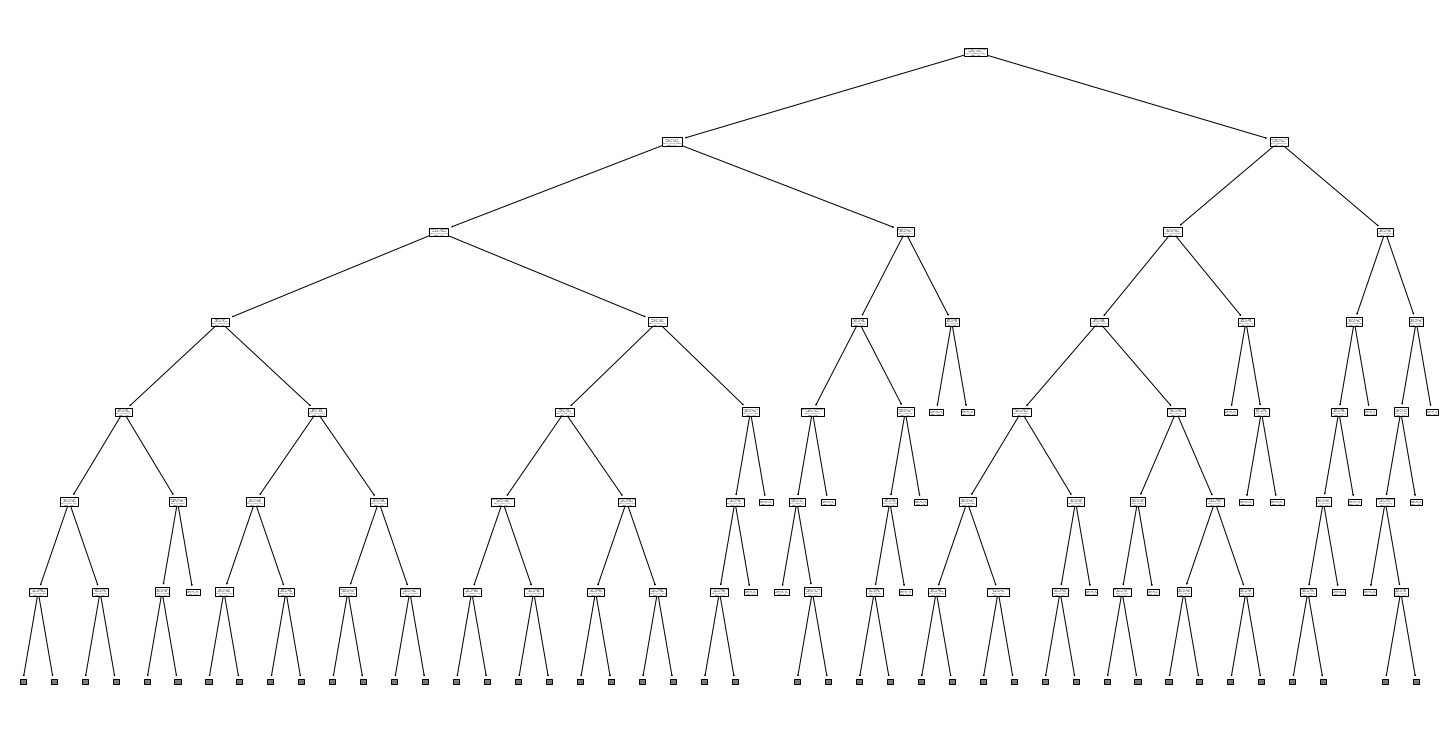

In [14]:
# Take the first decision tree
decision_tree = trf_cf.estimators_[0]

# Call the sklearn API to draw the decision tree
fig, ax = plt.subplots(figsize=(20, 10))
sklearn_tree.plot_tree(decision_tree, max_depth=6, ax=ax, feature_names=data_pp.features, class_names=True)
plt.gca().set_position([0, 0, 1, 1])
plt.savefig("decision_tree_1.svg")

Draw the first Hoeffding tree in ARF.


(dot.exe:2760): Pango-WARNING **: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.

(dot.exe:13288): Pango-WARNING **: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


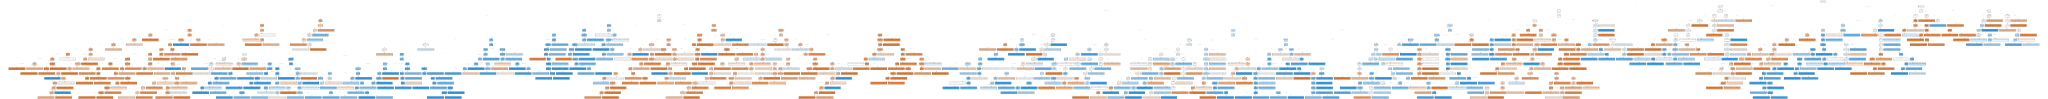

In [15]:
# Take the first hoeffding tree
tree_graph = arf_cf[0].model.draw()

# Call the graphviz API to draw the Hoeffding tree
fie_ext = 'svg'
filename = 'hoeffding_tree_1'
# tree_graph = graphviz.Source(tree_graph_data)
tree_graph.render(filename, format=fie_ext, view=False)
tree_graph

**Method 2: Comparing the number of nodes in both ARF and TRF**

If the total number nodes in both ARF and TRF are the same, then the transfer learning algorithm is successful.

The number of nodes can be compared by getting the attributes for the respective base learners.

In [16]:
node_counts = {
    'TRF': [],
    'ARF': [],
    'match': []
}

for idx, (dt, ht) in enumerate(zip(trf_cf.estimators_, arf_cf)):
    dt_nc = dt.tree_.node_count
    ht_nc = ht.model.n_nodes
    node_counts['TRF'].append(dt_nc)
    node_counts['ARF'].append(ht_nc)
    node_counts['match'].append(dt_nc == ht_nc)

node_counts = pd.DataFrame(node_counts)
node_counts.index = [idx + 1 for idx in range(len(arf_cf))]
node_counts

,TRF,ARF,match
1,1205,1205,True
2,965,965,True
3,1033,1033,True
4,979,979,True
5,1117,1117,True
6,1241,1241,True
7,1197,1197,True
8,1217,1217,True
9,1041,1041,True
10,1185,1185,True


**Method 3: Comparing the tree structures**

A test is conducted to ensure that all the nodes are placed at the right place in the ARF. 
The first code block outputs a log file named `arf_debug.txt`. The second code block outputs a log file named `trf_debug.txt`.  Both file contents must look the same to prove the right placements of all nodes. Each record in the file represents the location of the current internal node, and its children nodes' indexes and counts.

In [17]:
# Initialize a new ARF to prevent overwriting on existing ARF
arf_cf_tmp = AdaptiveRandomForestClassifier(**river_arf_cf_params)

# Override the max features and initialize the base learners
feature_names = data_pp.features
nominal_attrs = data_pp.nominal_attrs
arf_cf_tmp._init_ensemble(feature_names)

# Fetch the first decision tree to perform the testing
decision_tree = trf_cf.estimators_[0]

transfer_tree_weights_test(
    arf_cf_tmp[0].model,
    decision_tree,
    train_preprocessed,
    trf_cf.classes_, 
    feature_names, 
    nominal_attrs
)


Time taken for testing the transfer learning: 208.67774558067322 seconds


In [18]:
dt = trf_cf.estimators_[0].tree_

queue = [(0, '')]

total_nodes = 0

with open(os.path.join(OUT_FOLDER_PATH, 'trf_debug.txt'), 'w') as f:
    while len(queue) > 0:
        node_idx, node_location = queue.pop(0)
        total_nodes += 1

        left_ch_idx  = dt.children_left[node_idx]
        right_ch_idx = dt.children_right[node_idx]

        if left_ch_idx != -1:
            new_node_location = node_location + '0'
            df_node_l = dt_fetch_data(dt, new_node_location, train_preprocessed)
            if df_node_l.shape[0] != 0:
                queue.append((left_ch_idx, new_node_location))

        if right_ch_idx != -1:
            new_node_location = node_location + '1'
            df_node_r = dt_fetch_data(dt, new_node_location, train_preprocessed)
            if df_node_r.shape[0] != 0:
                queue.append((right_ch_idx, new_node_location))

        # Write the record if and only if the current node is not the leaf node
        if left_ch_idx != -1 and right_ch_idx != -1:
            f.write(f'Node location: {node_location}\n')
            f.write(f'Left  child index: {left_ch_idx}\nCount: {df_node_l.shape[0]}\n')
            f.write(f'Right child index: {right_ch_idx}\nCount: {df_node_r.shape[0]}\n\n')

**Method 4: Training**

The transfer learning algorithm is also validated by incrementally training new samples on the ARF. The source code for training the adaptive random forest classifier can be found at **arf_training.py**. 

In [19]:
# Load adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_cf_weight_transferred.pkl'), 'rb') as f:
    arf_cf_tmp = pickle.load(f)

X_train_d_pp = data_pp.preprocess(X_train_drifted)

train_arf_cf(arf_cf_tmp, X_train_d_pp[:1000], y_train_drifted[:1000])

Training adaptive random forest algorithm: 100%|█| 1000/1000 [00:17<00:00, 57.6


(AdaptiveRandomForestClassifier([ForestMemberClassifier (
                                   index_original=0
                                   model=BaseTreeClassifier (
                                     max_features=6
                                     grace_period=50
                                     max_depth=inf
                                     split_criterion="gini"
                                     split_confidence=0.01
                                     tie_threshold=0.05
                                     leaf_prediction="mc"
                                     nb_threshold=0
                                     nominal_attributes=['car_0.0', 'car_1.0', 'car_2.0', 'car_3.0', 'car_4.0', 'car_5.0', 'car_6.0', 'car_7.0', 'car_8.0', 'car_9.0', 'car_10.0', 'car_11.0', 'car_12.0', 'car_13.0', 'car_14.0', 'car_15.0', 'car_16.0', 'car_17.0', 'car_18.0', 'car_19.0', 'zipcode_0.0', 'zipcode_1.0', 'zipcode_2.0', 'zipcode_3.0', 'zipcode_4.0', 'zipcode_5.0', 'zipcode_6

**Method 5: Performance analysis**

The source code is in *FYP2_ARF_CF_Performance_Analysis.ipynb*.